In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from helpers.Concurrent import create_thread_pool_executor
from helpers.MetaObject import MetaObject
from helpers.Jupyter import display_html

from helpers.features.Orb import OrbFeaturesConfig, OrbFeaturesIter, orb_features_load, orb_features_draw_key_points
from helpers.features.Sift import SiftFeaturesConfig, SiftFeaturesIter, sift_features_load, sift_features_draw_key_points

from helpers.dataset.PlantVillage import PlantVillageConfig, plant_village_load

In [2]:
#
# parametres dataset PlantVillage
#
config_overrides = MetaObject.from_json("config_overrides.json")
executor = create_thread_pool_executor(max_workers=None)

pv_config = PlantVillageConfig(executor)
if not config_overrides is None:
    MetaObject.override_from_object(pv_config, 
                                    config_overrides.dataset)

print("PlantVillage config")
display(pv_config.__dict__)

PlantVillage config


{'url': 'https://tinyurl.com/22tas3na',
 'install_path': 'dataset/PlantVillage.hd5',
 'species_disease_re': '(.*)(?:___)(.*)',
 'species_re': '(.*)(?:,_|_)(.*)',
 'label_separator': '_',
 'thumbnail_scale': 0.25,
 'force_download': False,
 'read_only': True,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x2a71d84bfd0>,
 'force_install': False}

In [3]:
#
# obtenir le dataset PlantVillage
#
if False:
    %prun pv_dataset = plant_village_load(pv_config)
else:
    pv_dataset = plant_village_load(pv_config)
    
if pv_dataset is None:
    display_html(f"<b>Invalid dataset</b>")
else:
    pv_dataframe = pd.DataFrame(pv_dataset.dataframe)

print("PlantVillage", pv_dataframe.shape)
display( pv_dataframe.head() )

PlantVillage (60343, 5)


species     disease       label  \
0   Apple  Apple_scab  Apple_scab   
1   Apple  Apple_scab  Apple_scab   
2   Apple  Apple_scab  Apple_scab   
3   Apple  Apple_scab  Apple_scab   
4   Apple  Apple_scab  Apple_scab   

                                          image_path  \
0  Plant_leave_diseases_dataset_with_augmentation...   
1  Plant_leave_diseases_dataset_with_augmentation...   
2  Plant_leave_diseases_dataset_with_augmentation...   
3  Plant_leave_diseases_dataset_with_augmentation...   
4  Plant_leave_diseases_dataset_with_augmentation...   

                                      thumbnail_path  
0  thumbnails/Plant_leave_diseases_dataset_with_a...  
1  thumbnails/Plant_leave_diseases_dataset_with_a...  
2  thumbnails/Plant_leave_diseases_dataset_with_a...  
3  thumbnails/Plant_leave_diseases_dataset_with_a...  
4  thumbnails/Plant_leave_diseases_dataset_with_a...

In [18]:
#
# parametres pour features
#
features_config = OrbFeaturesConfig(executor)
if not config_overrides is None:
    MetaObject.override_from_object(features_config, 
                                    config_overrides.orb_features)

print("features_config")
display(features_config.__dict__)

#
# obtenir les features pour chaque image
#
orb_iter = OrbFeaturesIter(pv_dataset.zip_file, 
                           pv_dataframe["image_path"].iteritems(),
                           pv_dataframe.shape[0])

if "features_orb" in locals():
    del features_orb    

if False:
    %prun features_orb = orb_features_load(features_config, orb_iter)
else:
    features_orb = orb_features_load(features_config, orb_iter)

print("ORB features", features_orb.features.shape)
print("ORB keypoints", features_orb.key_points.shape)

features_config


{'install_path': 'dataset/OrbFeatures.hd5',
 'force_generate': False,
 'read_only': True,
 'nfeatures': 500,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x2a71d84bfd0>,
 'chunk_size': 150}

ORB features (20908751, 32)
ORB keypoints (20908751, 7)


In [17]:
sift_features_config = SiftFeaturesConfig(executor)
if not config_overrides is None:
    MetaObject.override_from_object(sift_features_config, 
                                    config_overrides.sift_features)

print("sift features_config")
display(sift_features_config.__dict__)


sift_iter = SiftFeaturesIter(pv_dataset.zip_file, 
                             pv_dataframe["image_path"].iteritems(),
                             pv_dataframe.shape[0])

if "features_sift" in locals():
    del features_sift

if False:
    %prun features_sift = orb_features_load(sift_features_config, sift_iter)
else:
    features_sift = orb_features_load(sift_features_config, sift_iter)

print("SIFT features", features_sift.features.shape)
print("SIFT keypoints", features_sift.key_points.shape)

sift features_config


{'install_path': 'dataset/SiftFeatures.hd5',
 'force_generate': False,
 'read_only': True,
 'nfeatures': 500,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x2a71d84bfd0>,
 'chunk_size': 150}

SIFT features (14386568, 128)
SIFT keypoints (14386568, 7)


In [21]:
index_start = random.randint(0, pv_dataframe.shape[0])
index_count = 3 * 4

indices = slice(index_start, index_start + index_count - 1)

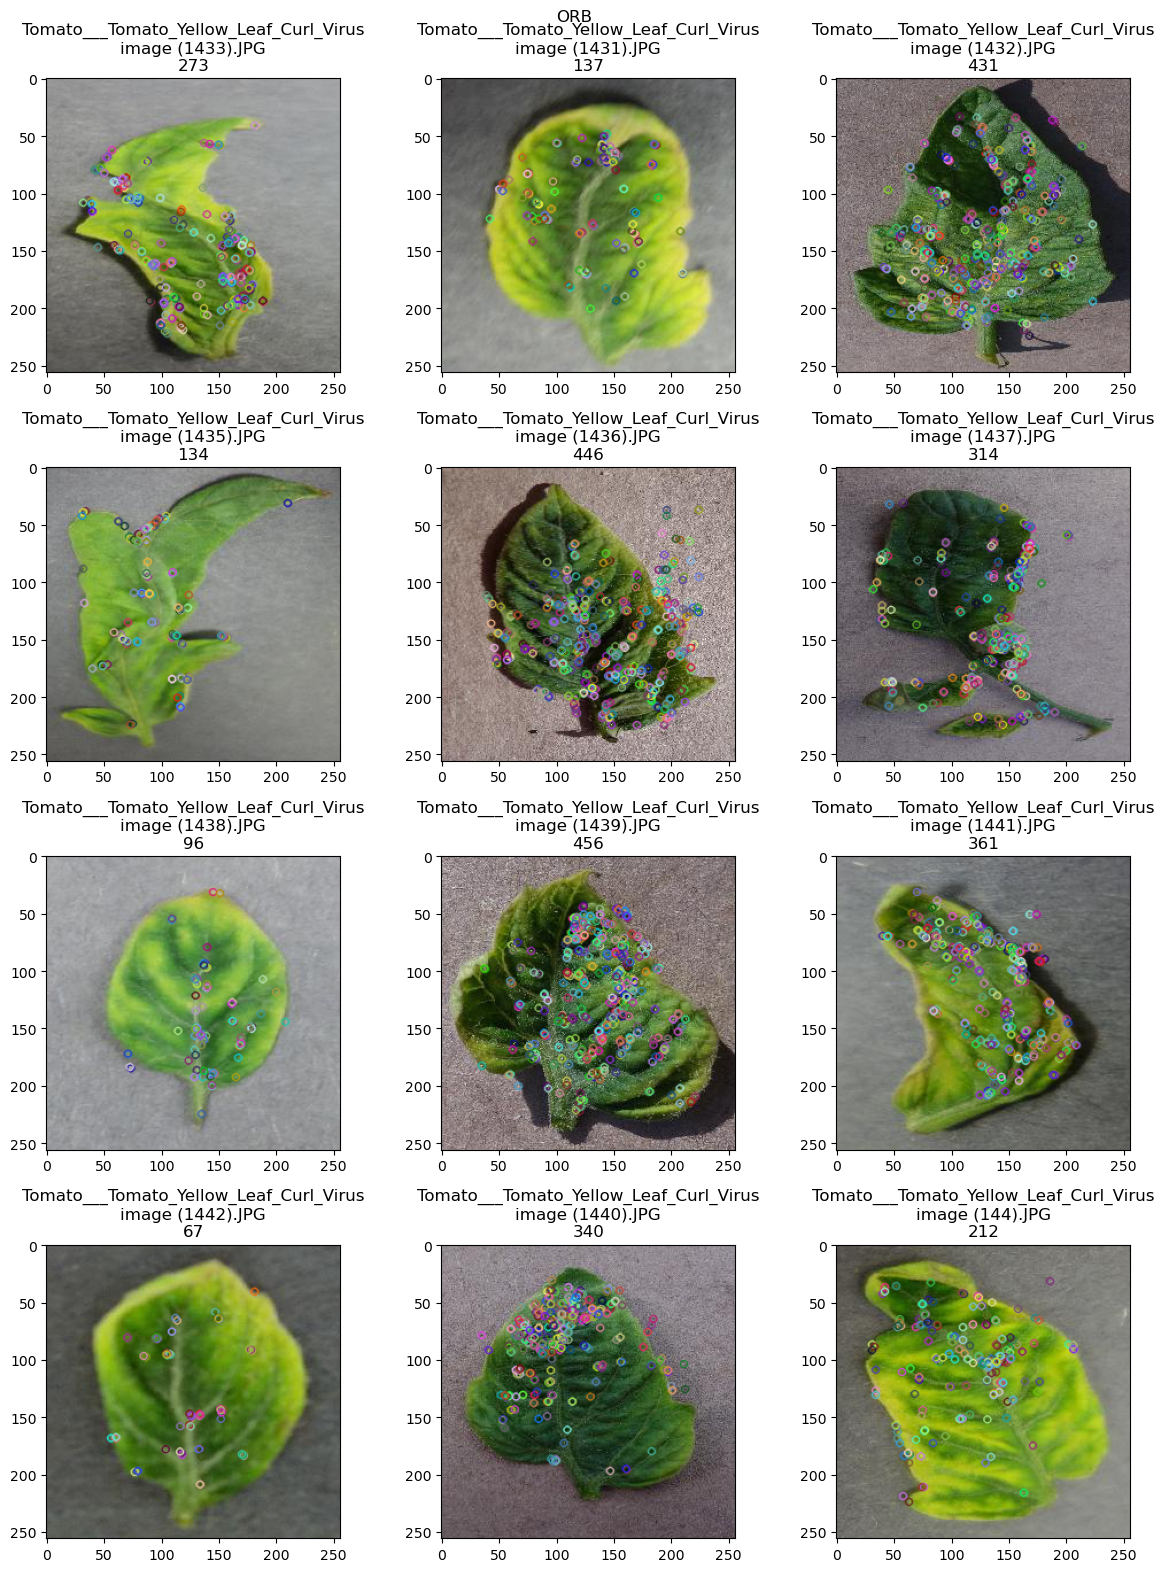

In [22]:
orb_iter = OrbFeaturesIter(pv_dataset.zip_file, 
                           pv_dataframe.loc[indices, "image_path"].iteritems())

num_rows = int(index_count / 3 + 0.5)
_, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows * 4))
for ax, \
   (image_index, \
    image_path, \
    key_points_count, \
    key_points_image) in zip(axes.flatten(), orb_features_draw_key_points(features_orb, orb_iter)):
    plt.sca(ax)
    
    head, tail = os.path.split(image_path)
    _, head = os.path.split(head)
    
    plt.title(head + "\n" + tail + "\n" + str(key_points_count))
    plt.imshow(key_points_image)

plt.suptitle("ORB")
plt.tight_layout()
plt.show()

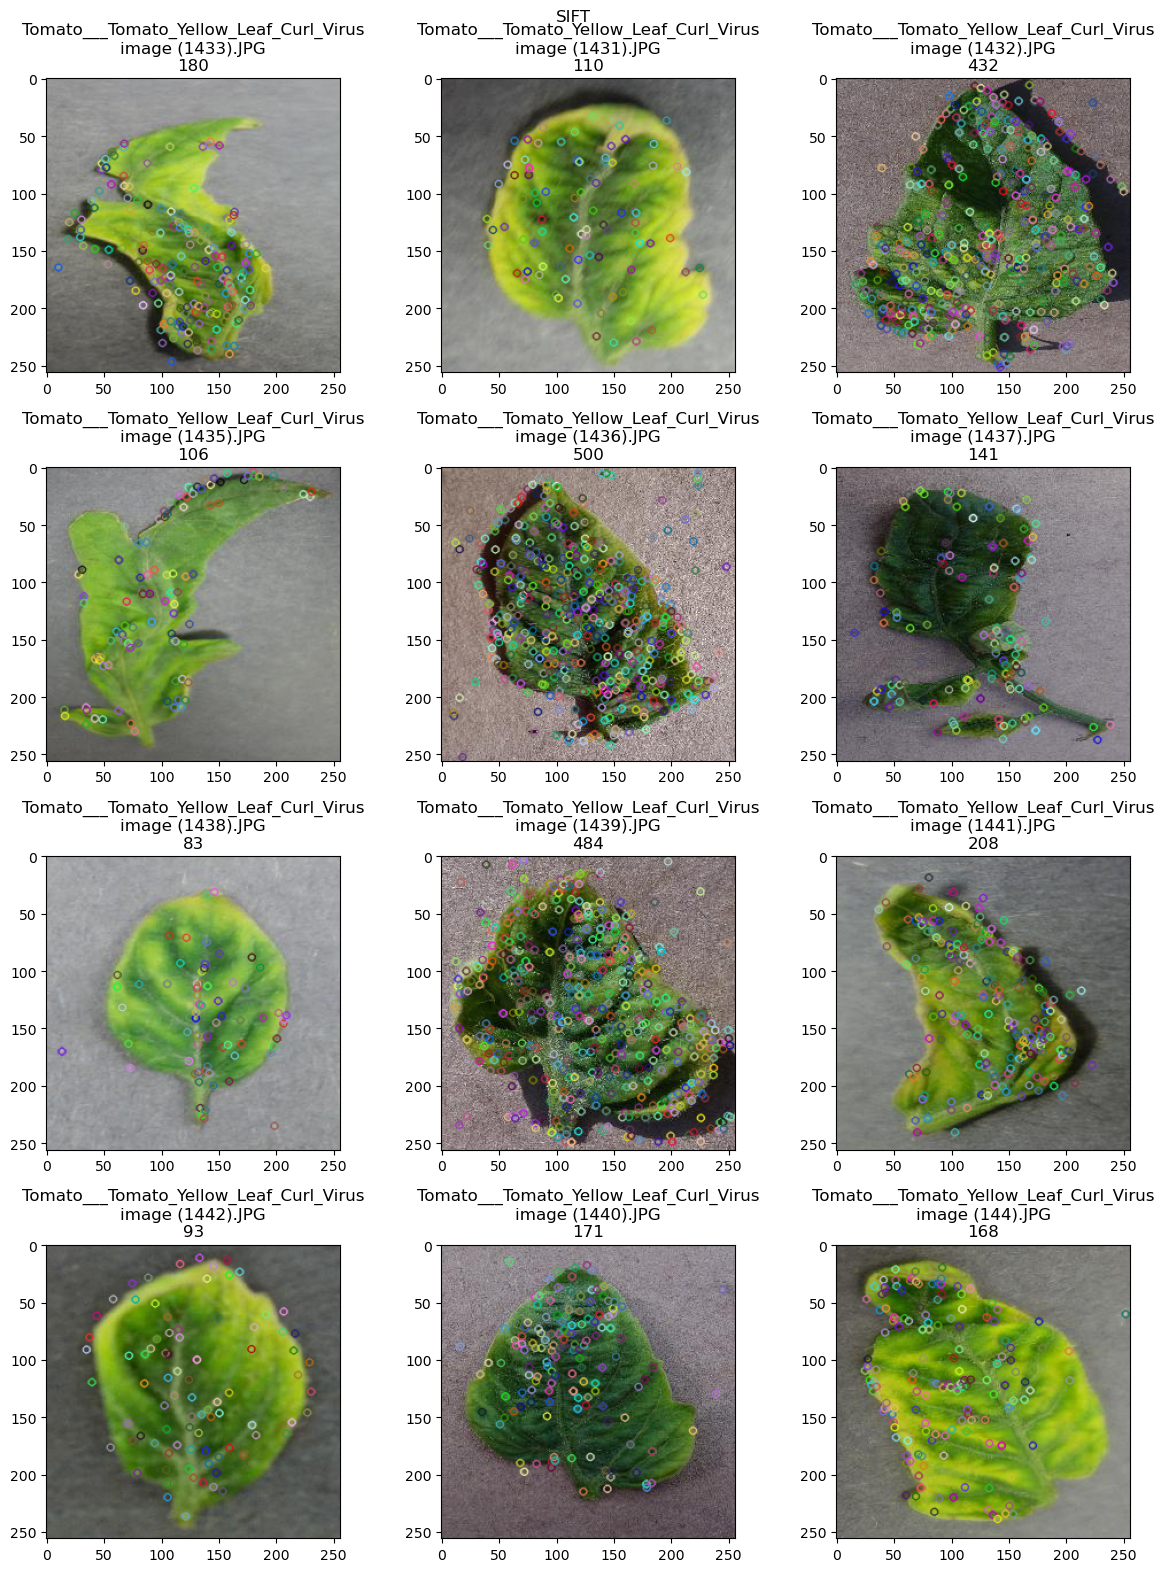

In [23]:
sift_iter = SiftFeaturesIter(pv_dataset.zip_file, 
                             pv_dataframe.loc[indices, "image_path"].iteritems())

num_rows = int(index_count / 3 + 0.5)
_, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows * 4))
for ax, \
   (image_index, \
    image_path, \
    key_points_count, \
    key_points_image) in zip(axes.flatten(), sift_features_draw_key_points(features_sift, sift_iter)):
    plt.sca(ax)
    
    head, tail = os.path.split(image_path)
    _, head = os.path.split(head)
    
    plt.title(head + "\n" + tail + "\n" + str(key_points_count))
    plt.imshow(key_points_image)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show()

In [7]:
#
# reduire la quantity de features avec KMeans 
#

In [ ]:
# #
# # split train/test
# #
# train, test = train_test_split(pv_dataframe, 
#                                train_size=0.8, 
#                                random_state=42, 
#                                stratify=pv_dataframe["label"])

# print(train.shape)
# print(test.shape)